In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr
import random
import statistics as st #for the mode
from sklearn.utils import shuffle
import random
from scipy import stats

#PCA
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import preprocessing

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent, mssd
import config_origins as config

2


C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
if not os.path.exists(path_extracted_data_visual_corr):
    os.makedirs(path_extracted_data_visual_corr)
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')
print(id_run)

change the configuration file if not done yet!
ALLDATA_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [4]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))

130


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#focal birds info to control for some variables
df_FB = pd.read_csv(os.path.join(config.path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';')
df_FB['early_death'] = df_FB['early_death'].fillna(0).replace(2,1) #2 means not sure
df_FB.rename(columns={'29-09 weight':'InitialWeight','R-Pen':'RearingPenID'}, inplace=True)
display(df_FB['early_death'].value_counts())
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    222
1.0     10
Name: early_death, dtype: int64

(232, 14)


,HenID,PenID,CLASS,RearingPenID,InitialStartDate,early_death,InitialWeight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#HA&KBF&weight
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
print(df_HA.shape)
df_HA = df_HA[df_HA['HenID'].isin(li_selected_hens)]
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
print(df_HA.shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(846, 58)
(534, 58)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,actual_path_img,imageID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,482.0,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp
3,M,16:26,pen3,51grey,normal,100.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,214.0,238.0,40,1.0,51grey3sp,NaN,NaN,"['', '51', 'grey', '3', 'sp']",sp
4,C,08:58,pen12,32orange,normal,25.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,68.0,319.0,2,0.0,32orange12sb,NaN,NaN,"['', '32', 'orange', '12', 'sb']",sb


In [7]:
#dailyMVT var
df_MVT_ALL = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']<=config.max_date_adaptability]
print(df_MVT_ALL.shape)
#make sure we have their mvt
df_MVT_ALL = df_MVT_ALL[~df_MVT_ALL['perc_duration_5_Zone'].isnull()]
print(df_MVT_ALL.shape)
#df_HA[['HAID','date']].drop_duplicates()
df_MVT_ALL.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42300, 63)
(6105, 63)
(6105, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
3,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,0.0,5_Zone,1.0,0.000000,0.000000,100.0,NaN,NaN,NaN,5
4,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,0.0,3_Zone,1.0,33.333333,50.000000,100.0,NaN,NaN,NaN,3
5,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,8.0,5_Zone,0.0,33.333333,66.666667,100.0,NaN,NaN,NaN,5


In [8]:
print(list(df_MVT_ALL))

['HenID', 'PenID', 'CLASS', 'TagID', 'FocalLegringName', 'R-Pen', 'InitialStartDate', 'Treatment', 'level', 'DIB', 'WIB', 'DOA', 'WOA', 'verification_daily_total_duration', 'TrackingSystemID', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_1_Zone_perh', 'nbr_stays_2_Zone_perh', 'nbr_stays_3_Zone_perh', 'nbr_stays_4_Zone_perh', 'nbr_stays_5_Zone_perh', 'ratio_percdur_percstays_2_Zone', 'ratio_percdur_percstays_3_Zone', 'ratio_percdur_percstays_4_Zone', 'ratio_percdur_percstays_5_Zone', 'latency_2_Zone_h', 'latency_3_Zone_h', 'latency_4_Zone_h', 'latency_5_Zone_h', 'latency_since15mnnestbox_h', 'Total_number_transition', 'nbr_stays_total', 'distribution_entropy', 'Total_number_zone', 'Max_duration_zones', 'vertical_travel_distance', 'ver

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


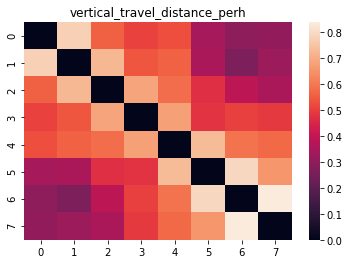

In [9]:
for var in ['vertical_travel_distance_perh']:
    df_corr = df_MVT_ALL.groupby(['WIB','HenID'])[var].agg(lambda x: np.mean(x)).reset_index()
    df_corr = df_corr.pivot(index='HenID', columns='WIB', values=var).reset_index()
    df_corr
    li_dico = []
    M = np.zeros(shape=(8,8))
    for i in range(1,8):
        for j in range(i+1,9):
            coeff, p_val = pearsonr(df_corr[i].tolist(), df_corr[j].tolist())
            coeff_np, p_val_np = spearmanr(df_corr[i].tolist(), df_corr[j].tolist())
            if p_val<0.05:
                M[i-1][j-1] = coeff_np
                M[j-1][i-1] = coeff_np
            else:
                M[i-1][j-1] = 0
                M[j-1][i-1] = 0
            li_dico.append({'WIB1':i,'WIB2':j,'coeff':coeff, 'p_val':p_val, 'coeff_np':coeff_np, 'p_val_np':p_val_np})
    df_corrres = pd.DataFrame(li_dico)
    #display(df_corrres)
    plt.title(var)
    sns.heatmap(M);
    plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


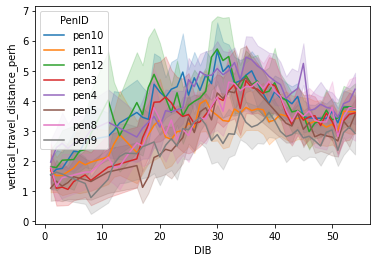

In [10]:
sns.lineplot(y='vertical_travel_distance_perh', x='DIB', data=df_MVT_ALL, hue='PenID');#,legend=False);

# choose data for individuality variables

In [11]:
#add a useful id
df_MVT_ALL['WIB_HenID'] = df_MVT_ALL.apply(lambda x: str(x['WIB'])+'_'+x['HenID'], axis=1)
df_MVT_ALL.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight,WIB_HenID
3,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,5_Zone,1.0,0.000000,0.000000,100.0,NaN,NaN,NaN,5,1_hen_131
4,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,3_Zone,1.0,33.333333,50.000000,100.0,NaN,NaN,NaN,3,1_hen_131
5,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,5_Zone,0.0,33.333333,66.666667,100.0,NaN,NaN,NaN,5,1_hen_131


### keep only the TRAN birds to better represent reality

df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['Treatment']=='TRAN'].copy()
len(df_MVT_ALL['HenID'].unique())

### keep only days since WG is open

In [12]:
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']>=config.date_first_opening_WG]
df_MVT_ALL.shape

(6105, 64)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5259, 64)

### add variable to account for difference between individual: mean DIB over the week

In [13]:
df_inddiff = df_MVT_ALL.groupby(['WIB','HenID','WIB_HenID'])['DIB'].agg(lambda x: list(x)).reset_index()
df_inddiff['avgDIB'] = df_inddiff['DIB'].map(lambda x: np.mean(x))
display(df_inddiff.head(3))
display(df_inddiff.tail(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,WIB_HenID,DIB,avgDIB
0,2,hen_1,2_hen_1,"[11, 12, 13, 14]",12.5
1,2,hen_10,2_hen_10,"[11, 12, 13]",12.0
2,2,hen_101,2_hen_101,[11],11.0


,WIB,HenID,WIB_HenID,DIB,avgDIB
907,8,hen_97,8_hen_97,"[50, 51, 52, 53, 54]",52.0
908,8,hen_98,8_hen_98,"[50, 51, 52, 53, 54]",52.0
909,8,hen_99,8_hen_99,"[50, 51, 52, 53, 54]",52.0


In [14]:
df_inddiff[df_inddiff['HenID']=='hen_131']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,WIB_HenID,DIB,avgDIB
27,2,hen_131,2_hen_131,"[11, 12, 13]",12.0
157,3,hen_131,3_hen_131,"[16, 17, 18, 19, 20, 21]",18.5
287,4,hen_131,4_hen_131,"[22, 23, 24, 25, 26, 27, 28]",25.0
417,5,hen_131,5_hen_131,"[29, 30, 31, 32, 33, 34, 35]",32.0
547,6,hen_131,6_hen_131,"[36, 37, 38, 39, 40, 41, 42]",39.0
677,7,hen_131,7_hen_131,"[43, 44, 45, 46, 47, 48, 49]",46.0
807,8,hen_131,8_hen_131,"[50, 51, 52, 53, 54]",52.0


In [15]:
df_inddiff[df_inddiff['HenID']=='hen_123']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,WIB_HenID,DIB,avgDIB
21,2,hen_123,2_hen_123,[11],11.000000
151,3,hen_123,3_hen_123,"[16, 17, 18, 19, 20, 21]",18.500000
281,4,hen_123,4_hen_123,"[22, 24, 25, 26, 27, 28]",25.333333
411,5,hen_123,5_hen_123,"[29, 30, 31, 32, 33, 34, 35]",32.000000
541,6,hen_123,6_hen_123,"[36, 37, 38, 39, 40, 41, 42]",39.000000
671,7,hen_123,7_hen_123,"[43, 44, 45, 46, 47, 48, 49]",46.000000
801,8,hen_123,8_hen_123,"[50, 51, 52, 53, 54]",52.000000


In [16]:
dico_WIBhenID_avgDIB = dict(zip(df_inddiff.WIB_HenID, df_inddiff.avgDIB))
#dico_WIBhenID_avgDIB
df_MVT_ALL['avgDIB'] = df_MVT_ALL['WIB_HenID'].map(lambda x: dico_WIBhenID_avgDIB[x])
df_MVT_ALL.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight,WIB_HenID,avgDIB
10,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-10,11,...,1.0,10.000000,66.666667,100.0,False,0.0,0.0,5,2_hen_131,12.0
11,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-11,12,...,1.0,10.000000,0.000000,100.0,False,0.0,0.0,5,2_hen_131,12.0
12,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-12,13,...,1.0,33.333333,50.000000,100.0,False,0.0,0.0,3,2_hen_131,12.0


### add external temperature as environemntal factor

In [17]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


In [18]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
df_wday.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


In [19]:
print(df_MVT_ALL.shape)
df_MVT_ALL['date'] = df_MVT_ALL['level'].map(lambda x: dt.datetime.date(x))
df_MVT_ALL= pd.merge(df_MVT_ALL, df_wday, on='date', how='left')
print(df_MVT_ALL.shape)
df_MVT_ALL.head(2)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5259, 65)
(5259, 68)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight,WIB_HenID,avgDIB,date,temperature_C,temperature_C_avg
0,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-10,11,...,100.0,False,0.0,0.0,5,2_hen_131,12.0,2020-10-10,"[11, 11, 12, 12, 11, 12]",11.500000
1,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-11,12,...,100.0,False,0.0,0.0,5,2_hen_131,12.0,2020-10-11,"[10, 9, 11, 11, 10, 10]",10.166667


### initial conditions

In [20]:
df_FB[['HenID','early_death','RearingPenID','InitialWeight']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,early_death,RearingPenID,InitialWeight
0,hen_1,0.0,1.0,1134.0
1,hen_10,0.0,1.0,1070.0
2,hen_100,0.0,3.0,1182.0


In [21]:
print(df_MVT_ALL.shape)
df_MVT_ALL = pd.merge(df_MVT_ALL, df_FB[['HenID','early_death','RearingPenID','InitialWeight']], on='HenID', how='left')
print(df_MVT_ALL.shape)
df_MVT_ALL.head(2)

(5259, 68)
(5259, 71)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,perc_1_Zone_while_WG_open,SleepingHeight,WIB_HenID,avgDIB,date,temperature_C,temperature_C_avg,early_death,RearingPenID,InitialWeight
0,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-10,11,...,0.0,5,2_hen_131,12.0,2020-10-10,"[11, 11, 12, 12, 11, 12]",11.500000,0.0,4.0,1202.0
1,hen_131,pen10,EPI,tag_128,19black,4.0,2020-06-10 00:00:00,TRAN,2020-10-11,12,...,0.0,5,2_hen_131,12.0,2020-10-11,"[10, 9, 11, 11, 10, 10]",10.166667,0.0,4.0,1202.0


### class

In [22]:
dico_cl = {'EPI':'Other','MEXP':'MEXP','LEXP':'LEXP','LEXPLOST':'Other','MEXPLOST':'Other'}
df_MVT_ALL['CLASS'] = df_MVT_ALL['CLASS'].map(lambda x: dico_cl[x])
df_MVT_ALL['CLASS'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Other    2795
MEXP     1421
LEXP     1043
Name: CLASS, dtype: int64

# PCA preprocessing

In [23]:
print(list(df_MVT_ALL.columns))

['HenID', 'PenID', 'CLASS', 'TagID', 'FocalLegringName', 'R-Pen', 'InitialStartDate', 'Treatment', 'level', 'DIB', 'WIB', 'DOA', 'WOA', 'verification_daily_total_duration', 'TrackingSystemID', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_1_Zone_perh', 'nbr_stays_2_Zone_perh', 'nbr_stays_3_Zone_perh', 'nbr_stays_4_Zone_perh', 'nbr_stays_5_Zone_perh', 'ratio_percdur_percstays_2_Zone', 'ratio_percdur_percstays_3_Zone', 'ratio_percdur_percstays_4_Zone', 'ratio_percdur_percstays_5_Zone', 'latency_2_Zone_h', 'latency_3_Zone_h', 'latency_4_Zone_h', 'latency_5_Zone_h', 'latency_since15mnnestbox_h', 'Total_number_transition', 'nbr_stays_total', 'distribution_entropy', 'Total_number_zone', 'Max_duration_zones', 'vertical_travel_distance', 'ver

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#reduce to what we need and add normalized data (keeping both)
#without WG as not existing in week 1
li_var = ['perc_duration_5_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone','perc_1_Zone_while_WG_open',
          'nbr_stays_2_Zone_perh', 'nbr_stays_3_Zone_perh', 'nbr_stays_5_Zone_perh','nbr_stays_1_Zone_perh',
          'in_WG_15mnAfterOpening','distribution_entropy', 'SleepingHeight','vertical_travel_distance_perh']
li_pca = ['normalize_'+i for i in li_var]
df_MVT_ALL[li_pca] = preprocessing.normalize(df_MVT_ALL[li_var])
df_MVT = df_MVT_ALL[['WIB','HenID','DIB','avgDIB','CLASS','TrackingSystemID','PenID','temperature_C_avg',
                     'early_death','RearingPenID','InitialWeight','Treatment']+li_var+li_pca].copy()
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,DIB,avgDIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,early_death,RearingPenID,...,normalize_perc_duration_2_Zone,normalize_perc_1_Zone_while_WG_open,normalize_nbr_stays_2_Zone_perh,normalize_nbr_stays_3_Zone_perh,normalize_nbr_stays_5_Zone_perh,normalize_nbr_stays_1_Zone_perh,normalize_in_WG_15mnAfterOpening,normalize_distribution_entropy,normalize_SleepingHeight,normalize_vertical_travel_distance_perh
0,2,hen_131,11,12.0,Other,TrackingSystem 10-12,pen10,11.500000,0.0,4.0,...,0.815576,0.0,0.012878,0.014308,0.004293,0.0,0.0,0.016652,0.071542,0.035771
1,2,hen_131,12,12.0,Other,TrackingSystem 10-12,pen10,10.166667,0.0,4.0,...,0.858344,0.0,0.012664,0.014071,0.001407,0.0,0.0,0.016041,0.070356,0.029550
2,2,hen_131,13,12.0,Other,TrackingSystem 10-12,pen10,9.000000,0.0,4.0,...,0.655207,0.0,0.010625,0.014167,0.007083,0.0,0.0,0.030777,0.053125,0.042500


# PCA on first obs. / week / ind

In [25]:
#df to do PCA on first observation per week per bird 
df_pca = df_MVT.groupby(['WIB','HenID'])[li_pca].agg(lambda x: list(x)[0]).reset_index()
df_pca.head(3)

#PCA with two components
pca = PCA(n_components=2)
X = df_pca[li_pca]
pca.fit(X)

#eigenvectores and eigenvules: pca.components_ has shape [n_components, n_features]
df_pca_res = pd.DataFrame(pca.components_, columns=li_pca)
df_pca_res['component_importance'] = pca.explained_variance_ratio_
df_pca_res['explained variance'] = pca.explained_variance_
df_pca_res

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,normalize_perc_duration_5_Zone,normalize_perc_duration_3_Zone,normalize_perc_duration_2_Zone,normalize_perc_1_Zone_while_WG_open,normalize_nbr_stays_2_Zone_perh,normalize_nbr_stays_3_Zone_perh,normalize_nbr_stays_5_Zone_perh,normalize_nbr_stays_1_Zone_perh,normalize_in_WG_15mnAfterOpening,normalize_distribution_entropy,normalize_SleepingHeight,normalize_vertical_travel_distance_perh,component_importance,explained variance
0,-0.713422,0.334002,0.610089,0.068254,0.018986,0.020079,-0.000638,0.005049,0.003054,0.012419,0.006988,0.040031,0.801106,0.257092
1,-0.118035,0.767697,-0.586815,0.224058,0.011357,0.016157,0.000292,0.011552,0.004777,0.015493,0.024172,0.028012,0.104524,0.033544


In [26]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=li_pca)
loading_matrix

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PC1,PC2
normalize_perc_duration_5_Zone,-0.361735,-0.021618
normalize_perc_duration_3_Zone,0.169353,0.140604
normalize_perc_duration_2_Zone,0.309341,-0.107476
normalize_perc_1_Zone_while_WG_open,0.034607,0.041036
normalize_nbr_stays_2_Zone_perh,0.009627,0.002080
normalize_nbr_stays_3_Zone_perh,0.010181,0.002959
normalize_nbr_stays_5_Zone_perh,-0.000323,0.000053
normalize_nbr_stays_1_Zone_perh,0.002560,0.002116
normalize_in_WG_15mnAfterOpening,0.001548,0.000875
normalize_distribution_entropy,0.006297,0.002838


In [27]:
#add PCA component per ind per day
df_MVT['tuple_PCA'] = df_MVT.apply(lambda x: pca.transform(np.array([x[li_pca]])), axis=1)
#only keep first one as explaines more than 80% of the var tot
df_MVT['PC1'] = df_MVT['tuple_PCA'].map(lambda x: x[0][0])
display(df_MVT.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,DIB,avgDIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,early_death,RearingPenID,...,normalize_nbr_stays_2_Zone_perh,normalize_nbr_stays_3_Zone_perh,normalize_nbr_stays_5_Zone_perh,normalize_nbr_stays_1_Zone_perh,normalize_in_WG_15mnAfterOpening,normalize_distribution_entropy,normalize_SleepingHeight,normalize_vertical_travel_distance_perh,tuple_PCA,PC1
0,2,hen_131,11,12.0,Other,TrackingSystem 10-12,pen10,11.500000,0.0,4.0,...,0.012878,0.014308,0.004293,0.0,0.0,0.016652,0.071542,0.035771,"[[0.6955999878285367, 0.08595714011064119]]",0.695600
1,2,hen_131,12,12.0,Other,TrackingSystem 10-12,pen10,10.166667,0.0,4.0,...,0.012664,0.014071,0.001407,0.0,0.0,0.016041,0.070356,0.029550,"[[0.6996218765086305, 0.010177046798324282]]",0.699622
2,2,hen_131,13,12.0,Other,TrackingSystem 10-12,pen10,9.000000,0.0,4.0,...,0.010625,0.014167,0.007083,0.0,0.0,0.030777,0.053125,0.042500,"[[0.11685466118325571, -0.00457759505510027]]",0.116855


In [28]:
from scipy.stats import pearsonr
print(pearsonr(df_MVT['PC1'].tolist(), df_MVT['normalize_SleepingHeight'].tolist()),
pearsonr(df_MVT['PC1'].tolist(), df_MVT['normalize_perc_duration_2_Zone'].tolist()))

(0.10479155110817993, 2.5653872278521132e-14) (0.9255907395839472, 0.0)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Validity of PC1 - PCA on full dataset

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


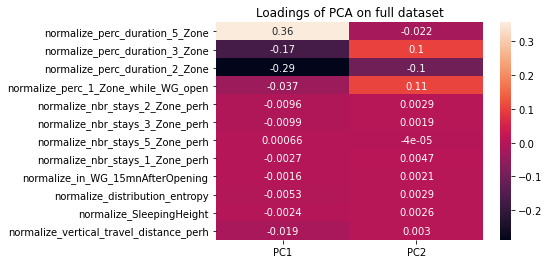

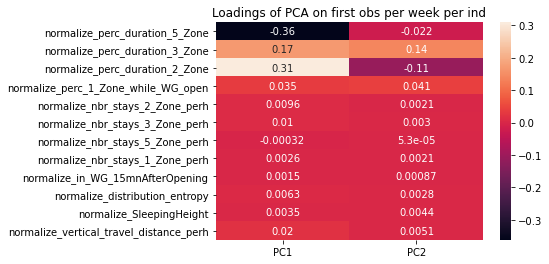

In [29]:
#df to do PCA on full dataset
df_pca_validity = df_MVT[li_pca].copy()
df_pca_validity.head(3)

#PCA with two components
pca_validity = PCA(n_components=2)
X = df_pca_validity[li_pca]
pca_validity.fit(X)

loadings_validity = pca_validity.components_.T * np.sqrt(pca_validity.explained_variance_)
loading_matrix_validity = pd.DataFrame(loadings_validity, columns=['PC1', 'PC2'], index=li_pca)

sns.heatmap(loading_matrix_validity[['PC1','PC2']], annot=True)
plt.title('Loadings of PCA on full dataset')
plt.savefig(os.path.join(path_extracted_data_adap,'Loadings of PCA performed on full dataset.png'), bbox_inches='tight')
plt.show()
sns.heatmap(loading_matrix[['PC1','PC2']], annot=True)
plt.title('Loadings of PCA on first obs per week per ind');
plt.savefig(os.path.join(path_extracted_data_adap,'Loadings of PCA performed on first obs per week per ind.png'), bbox_inches='tight')

# Save

In [30]:
df_MVT['PC1_standardized'] = preprocessing.scale(df_MVT['PC1'])
print(df_MVT.shape)
display(df_MVT.head(3))
df_MVT.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4individuality.csv'), index=False, sep=';')

(5259, 39)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,HenID,DIB,avgDIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,early_death,RearingPenID,...,normalize_nbr_stays_3_Zone_perh,normalize_nbr_stays_5_Zone_perh,normalize_nbr_stays_1_Zone_perh,normalize_in_WG_15mnAfterOpening,normalize_distribution_entropy,normalize_SleepingHeight,normalize_vertical_travel_distance_perh,tuple_PCA,PC1,PC1_standardized
0,2,hen_131,11,12.0,Other,TrackingSystem 10-12,pen10,11.500000,0.0,4.0,...,0.014308,0.004293,0.0,0.0,0.016652,0.071542,0.035771,"[[0.6955999878285367, 0.08595714011064119]]",0.695600,1.326127
1,2,hen_131,12,12.0,Other,TrackingSystem 10-12,pen10,10.166667,0.0,4.0,...,0.014071,0.001407,0.0,0.0,0.016041,0.070356,0.029550,"[[0.6996218765086305, 0.010177046798324282]]",0.699622,1.334329
2,2,hen_131,13,12.0,Other,TrackingSystem 10-12,pen10,9.000000,0.0,4.0,...,0.014167,0.007083,0.0,0.0,0.030777,0.053125,0.042500,"[[0.11685466118325571, -0.00457759505510027]]",0.116855,0.145793


In [31]:
#number of individual per class per week
df_MVT.groupby(['WIB','CLASS'])['HenID'].agg(lambda x: len(set(x))).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WIB,CLASS,HenID
0,2,LEXP,26
1,2,MEXP,35
2,2,Other,69
3,3,LEXP,26
4,3,MEXP,35
5,3,Other,69
6,4,LEXP,26
7,4,MEXP,35
8,4,Other,69
9,5,LEXP,26


# Visuals

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


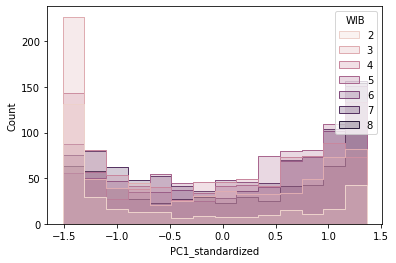

In [32]:
sns.histplot(df_MVT, x="PC1_standardized", hue="WIB", element="step");

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


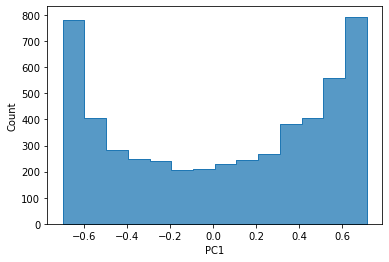

In [33]:
sns.histplot(df_MVT, x="PC1", element="step");

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


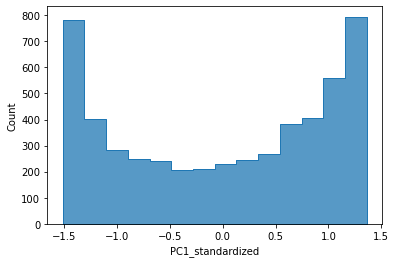

In [34]:
sns.histplot(df_MVT, x="PC1_standardized", element="step");

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


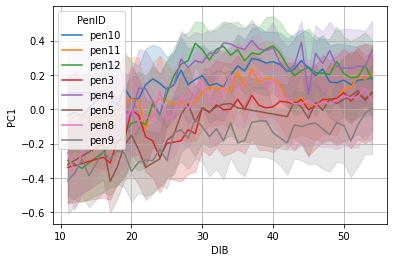

In [35]:
#plot plasticity over time
sns.lineplot(x='DIB', y='PC1', data=df_MVT, hue='PenID');
plt.grid()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


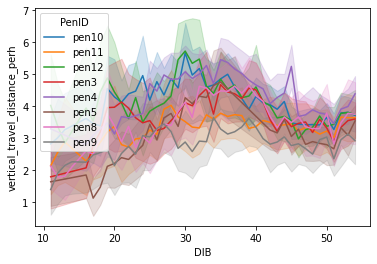

In [36]:
sns.lineplot(y='vertical_travel_distance_perh', x='DIB', data=df_MVT, hue='PenID');#,legend=False);